In [1]:
import os
os.chdir('..')

In [7]:
import torch
from torch import autograd
import torch.nn.functional as F
import pickle
import random

from nn_models import lbp_message_passing_network, GIN_Network_withEdgeFeatures
from ising_model.pytorch_dataset import build_factorgraph_from_SpinGlassModel
from ising_model.spin_glass_model import SpinGlassModel
from factor_graph import FactorGraphData
from factor_graph import DataLoader_custom as DataLoader_pytorchGeometric

from ising_model.pytorch_geometric_data import spinGlass_to_torchGeometric


import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import parameters
from parameters import ROOT_DIR, alpha, alpha2, SHARE_WEIGHTS, BETHE_MLP, NUM_MLPS
import cProfile

MODEL_MAP_FLAG = True
CLASSIFICATION_FLAG = True
TRAINING_FLAG = True
BETHE_MLP = False
ATTRACTIVE_FIELD = True
LEARNING_RATE = 0.005144
LR_DECAY_FLAG = False
ALPHA = 0.3
ALPHA2 = 0.5
MSG_PASSING_ITERS = 100
SHARE_WEIGHTS = True
LOSS_NAME = None
ONE_HOT_RATIO = 1.


MODE = "train"
TEST_TRAINED_MODEL = True 
EXPERIMENT_NAME = 'trained_MAP_attrField_100layer_2MLPs_noFinalBetheMLP/' #used for saving results when MODE='test'

USE_WANDB = False
####### Training PARAMETERS #######
MAX_FACTOR_STATE_DIMENSIONS = 2
EPSILON = 0 #set factor states with potential 0 to EPSILON for numerical stability
SHARE_WEIGHTS = True if not TRAINING_FLAG  else SHARE_WEIGHTS

MODEL_NAME = "Success_MAP_spinGlass_%dlayer_alpha=%f.pth" % (MSG_PASSING_ITERS, parameters.alpha)
TRAINED_MODELS_DIR = ROOT_DIR + "trained_models_map/" #trained models are stored here



##########################################################################################################
N_MIN_TRAIN = 10
N_MAX_TRAIN = 10
F_MAX_TRAIN = .1
C_MAX_TRAIN = 5.0
ATTRACTIVE_FIELD_TRAIN = ATTRACTIVE_FIELD

N_MIN_VAL = 10
N_MAX_VAL = 10
F_MAX_VAL = .1
C_MAX_VAL = 5.0
ATTRACTIVE_FIELD_VAL = ATTRACTIVE_FIELD
ATTRACTIVE_FIELD_TEST = ATTRACTIVE_FIELD

REGENERATE_DATA = False
DATA_DIR = "./data/spin_glass_map/"


TRAINING_DATA_SIZE = 50
VAL_DATA_SIZE = 50#100
TEST_DATA_SIZE = 200

TRAIN_BATCH_SIZE=50
VAL_BATCH_SIZE=50

EPOCH_COUNT = 10000 if TRAINING_FLAG else 5
PRINT_FREQUENCY = 10 if TRAINING_FLAG else 1
VAL_FREQUENCY = 10 if TRAINING_FLAG else 1
SAVE_FREQUENCY = 100 if TRAINING_FLAG else 1

TEST_DATSET = 'val' #can test and plot results for 'train', 'val', or 'test' datasets

##### Optimizer parameters #####
STEP_SIZE=(EPOCH_COUNT//4)
LR_DECAY=.5
if ATTRACTIVE_FIELD_TRAIN == True:
    #works well for training on attractive field
        LEARNING_RATE = LEARNING_RATE
#         LEARNING_RATE = 0.001 #testing
#     LEARNING_RATE = 0.00005 #10layer with Bethe_mlp
else:
    #think this works for mixed fields
#         LEARNING_RATE = 0.005 #10layer
#         LEARNING_RATE = 0.001 #30layer trial
    LEARNING_RATE = LEARNING_RATE
#     LEARNING_RATE = 0.0000005 #c_max = .5

def get_dataset(dataset_type, datasize=None):
    '''
    Store/load a list of SpinGlassModels
    When using, convert to BPNN or GNN form with either
    build_factorgraph_from_SpinGlassModel(pytorch_geometric=True) for BPNN or spinGlass_to_torchGeometric() for GNN
    '''
    assert(dataset_type in ['train', 'val', 'test'])
    if dataset_type == 'train':
        datasize = TRAINING_DATA_SIZE
        ATTRACTIVE_FIELD = ATTRACTIVE_FIELD_TRAIN
        N_MIN = N_MIN_TRAIN
        N_MAX = N_MAX_TRAIN
        F_MAX = F_MAX_TRAIN
        C_MAX = C_MAX_TRAIN
    elif dataset_type == 'val':
        datasize = datasize or VAL_DATA_SIZE
        ATTRACTIVE_FIELD = ATTRACTIVE_FIELD_VAL
        N_MIN = N_MIN_VAL
        N_MAX = N_MAX_VAL
        F_MAX = F_MAX_VAL
        C_MAX = C_MAX_VAL
    else:
        datasize = TEST_DATA_SIZE
        ATTRACTIVE_FIELD = ATTRACTIVE_FIELD_TEST

    dataset_file = DATA_DIR + dataset_type + '%d_%d_%d_%.2f_%.2f_attField=%s.pkl' % (datasize, N_MIN, N_MAX, F_MAX, C_MAX, ATTRACTIVE_FIELD)
    if REGENERATE_DATA or (not os.path.exists(dataset_file)):
        print("REGENERATING DATA!!")
        spin_glass_models_list = [SpinGlassModel(N=random.randint(N_MIN, N_MAX),\
                                                f=np.random.uniform(low=0, high=F_MAX),\
                                                c=np.random.uniform(low=0, high=C_MAX),\
                                                attractive_field=ATTRACTIVE_FIELD) for i in range(datasize)]
        if not os.path.exists(DATA_DIR):
            os.makedirs(DATA_DIR)
        with open(dataset_file, 'wb') as f:
            pickle.dump(spin_glass_models_list, f)
    else:
        with open(dataset_file, 'rb') as f:
            spin_glass_models_list = pickle.load(f)
    return spin_glass_models_list

device = torch.device('cpu')
lbp_net = lbp_message_passing_network(max_factor_state_dimensions=MAX_FACTOR_STATE_DIMENSIONS,\
                                      msg_passing_iters=MSG_PASSING_ITERS, device=None, bethe_MLP=BETHE_MLP,
                                      map_flag=MODEL_MAP_FLAG, marginal_flag=True, classification_flag=CLASSIFICATION_FLAG,
                                      share_weights=SHARE_WEIGHTS,
                                      alpha=ALPHA, alpha2=ALPHA2)

lbp_net = lbp_net.to(device)

torch.autograd.set_grad_enabled(False)

spin_glass_models_list_test = get_dataset(dataset_type='val', datasize=TEST_DATA_SIZE)
sg_models_fg_from_test = [build_factorgraph_from_SpinGlassModel(
    sg_model, map_flag=True, marginal_flag=True, classification_flag=CLASSIFICATION_FLAG,
) for sg_model in spin_glass_models_list_test]
test_data_loader_pytorchGeometric = DataLoader_pytorchGeometric(sg_models_fg_from_test, batch_size=TEST_DATA_SIZE, shuffle=False)

lbp_net.load_state_dict(torch.load(TRAINED_MODELS_DIR + MODEL_NAME))

 

learn_BP: True


<All keys matched successfully>

## Max-BPNN

In [8]:

def max_marginals(x, y, sg_model):
    if CLASSIFICATION_FLAG:
        x = torch.log(x[:,0:-1]/x[:,-1:])
        y = torch.log(y[:,0:-1]/y[:,-1:])
    state_x = (x<=0).float()
    state_y = (y<=0).float()
    score_x = sg_model.logScore(tuple(state_x.reshape(-1).tolist()))
    score_y = sg_model.logScore(tuple(state_y.reshape(-1).tolist()))
    lnZ = sg_model.junction_tree_libdai()
    prob_x, prob_y = np.exp(score_x-lnZ), np.exp(score_y-lnZ)
    return [prob_x, prob_y]
def same_states(x, y, sg_model):
    if CLASSIFICATION_FLAG:
        x = torch.log(x[:,0:-1]/x[:,-1:])
        y = torch.log(y[:,0:-1]/y[:,-1:])
    state_x = (x<=0).reshape(-1).tolist()
    state_y = (y<=0).reshape(-1).tolist()
    return [len(set(state_x))==1, len(set(state_y))==1]

model_index = 0
exact_marginals, estimated_marginals = [], []
exact_max_prob, estimated_max_prob = [], []
exact_same_states, estimated_same_states = [], []
for spin_glass_problem in test_data_loader_pytorchGeometric: #pytorch geometric form
    spin_glass_problem = spin_glass_problem.to(device)
    spin_glass_problem.facToVar_edge_idx = spin_glass_problem.edge_index #hack for batching, see FactorGraphData in factor_graph.py
    exact_marginals_function = spin_glass_problem.marginals
    assert((spin_glass_problem.state_dimensions == MAX_FACTOR_STATE_DIMENSIONS).all()), (spin_glass_problem.state_dimensions, MAX_FACTOR_STATE_DIMENSIONS)
    spin_glass_problem.state_dimensions = spin_glass_problem.state_dimensions[0] #hack for batching,
    estimated_marginals_function = lbp_net(spin_glass_problem)

    exact_marginals += exact_marginals_function.detach().cpu().tolist()
    estimated_marginals += estimated_marginals_function.detach().cpu().tolist()

    data_batch = spin_glass_problem.batch_vars
    model_num = torch.max(data_batch).item()+1
    for midx in range(model_num):
        x, y = estimated_marginals_function[data_batch==midx], exact_marginals_function[data_batch==midx]
        prob_x, prob_y = max_marginals(x, y, spin_glass_models_list_test[model_index+midx])
        same_x, same_y = same_states(x, y, spin_glass_models_list_test[model_index+midx])
        exact_max_prob.append(prob_y)
        estimated_max_prob.append(prob_x)
        exact_same_states.append(same_y)
        estimated_same_states.append(same_x)

    model_index += model_num

exact_marginals, estimated_marginals = np.array(exact_marginals), np.array(estimated_marginals)
exact_max_prob, estimated_max_prob = np.array(exact_max_prob), np.array(estimated_max_prob)
exact_same_states, estimated_same_states = np.array(exact_same_states), np.array(estimated_same_states)

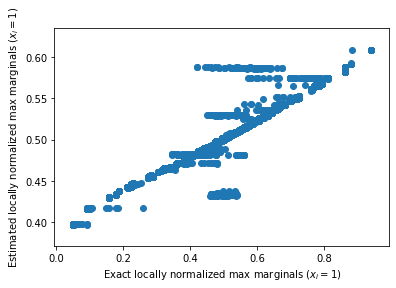

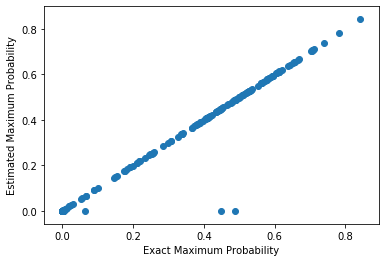

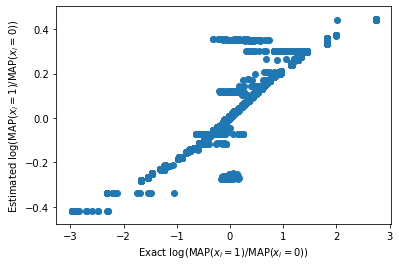

In [9]:
plt.scatter(exact_marginals[:,1], estimated_marginals[:,1])
plt.xlabel('Exact locally normalized max marginals ($x_i=1$)')
plt.ylabel('Estimated locally normalized max marginals ($x_i=1$)')
plt.show()
plt.scatter(exact_max_prob, estimated_max_prob)
plt.xlabel('Exact Maximum Probability')
plt.ylabel('Estimated Maximum Probability')
plt.show()
plt.scatter(np.log(exact_marginals[:,1]/exact_marginals[:,0]), 
            np.log(estimated_marginals[:,1]/estimated_marginals[:,0]))
plt.xlabel('Exact log(MAP($x_i=1$)/MAP($x_i=0$))')
plt.ylabel('Estimated log(MAP($x_i=1$)/MAP($x_i=0$))')
plt.show()

In [10]:
xlabel, ylabel = exact_marginals[:,1]>exact_marginals[:,0], estimated_marginals[:,1]>estimated_marginals[:,0]
print(np.mean(xlabel==ylabel))
print(np.mean(exact_max_prob==estimated_max_prob))
print(np.mean(exact_same_states))
print(np.mean(estimated_same_states))

0.98
0.95
0.975
0.975


## Loopy BP

In [7]:
exact_marginals, estimated_marginals = [], []
exact_max_prob, estimated_max_prob = [], []
for spin_glass_problem in test_data_loader_pytorchGeometric: #pytorch geometric form
    spin_glass_problem = spin_glass_problem.to(device)
    exact_marginals_function = spin_glass_problem.marginals
    exact_marginals += exact_marginals_function.detach().cpu().tolist()
    for mi, sg_model in enumerate(spin_glass_models_list_test):
        estimated_marginals.append(sg_model.marginal_loopyBP_libdai(map_flag=True, classification_flag=True,
                                                                   damping=ALPHA, maxiter=MSG_PASSING_ITERS,
                                                                   updates='PARALL'))
        exact_prob, estimated_prob = max_marginals(exact_marginals_function[data_batch==mi], 
                                                   torch.tensor(estimated_marginals[-1]), sg_model)
        exact_max_prob.append(exact_prob)
        estimated_max_prob.append(estimated_prob)

exact_marginals, estimated_marginals = np.array(exact_marginals).reshape([-1,2]), np.array(estimated_marginals).reshape([-1,2])
exact_max_prob, estimated_max_prob = np.array(exact_max_prob), np.array(estimated_max_prob)
print(exact_marginals.shape, estimated_marginals.shape, exact_max_prob.shape, estimated_max_prob.shape)

(20000, 2) (20000, 2) (200,) (200,)


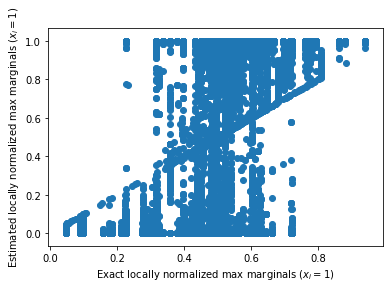

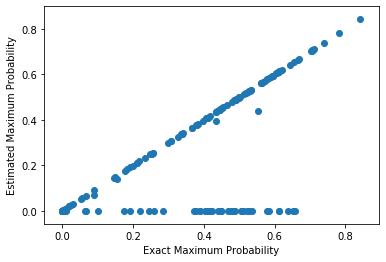

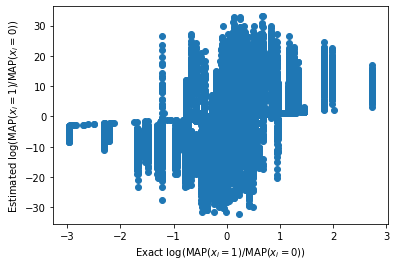

In [10]:
plt.scatter(exact_marginals[:,1], estimated_marginals[:,1])
plt.xlabel('Exact locally normalized max marginals ($x_i=1$)')
plt.ylabel('Estimated locally normalized max marginals ($x_i=1$)')
plt.show()
plt.scatter(exact_max_prob, estimated_max_prob)
plt.xlabel('Exact Maximum Probability')
plt.ylabel('Estimated Maximum Probability')
plt.show()
plt.scatter(np.log(exact_marginals[:,1]/exact_marginals[:,0]), 
            np.log(estimated_marginals[:,1]/estimated_marginals[:,0]))
plt.xlabel('Exact log(MAP($x_i=1$)/MAP($x_i=0$))')
plt.ylabel('Estimated log(MAP($x_i=1$)/MAP($x_i=0$))')
plt.show()

In [9]:
xlabel, ylabel = exact_marginals[:,1]>exact_marginals[:,0], estimated_marginals[:,1]>estimated_marginals[:,0]
print(np.mean(xlabel==ylabel))
print(np.mean(exact_max_prob==estimated_max_prob))

0.82775
0.64
